In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Set base directory paths
input_base_dir = 'OASIS_2'  # Replace with the actual path to your OASIS_2 folder
output_base_dir = 'Output'  # Replace with the desired output directory

# List of class names (directories)
class_names = ['Converted','Demented', 'Nondemented']

# Function to save axial, coronal, and sagittal views for each .nii file
def save_slices_for_nii(nii_file_path, output_class_dir, file_index):
    # Load the .nii file
    nifti_image = nib.load(nii_file_path)
    image_data = nifti_image.get_fdata()

    # Remove the extra dimension (size 1)
    image_data = np.squeeze(image_data)

    # Create output directories for axial, coronal, and sagittal views
    axial_dir = os.path.join(output_class_dir, 'axial')
    coronal_dir = os.path.join(output_class_dir, 'coronal')
    sagittal_dir = os.path.join(output_class_dir, 'sagittal')

    os.makedirs(axial_dir, exist_ok=True)
    os.makedirs(coronal_dir, exist_ok=True)
    os.makedirs(sagittal_dir, exist_ok=True)

    # Get the number of axial slices (along the Z-axis)
    num_axial_slices = image_data.shape[2]

    # Save all axial slices (slices along the Z-axis)
    for i in range(num_axial_slices):
        axial_slice = image_data[:, :, i]
        plt.imsave(os.path.join(axial_dir, f'{file_index}_{i+1}.png'), axial_slice, cmap='gray', format='png')

    # Resize and save coronal slices (slices along the Y-axis)
    num_coronal_slices = image_data.shape[1]
    step_size_coronal = max(1, num_coronal_slices // num_axial_slices)
    for i in range(num_axial_slices):
        coronal_slice = image_data[:, i * step_size_coronal, :]
        plt.imsave(os.path.join(coronal_dir, f'{file_index}_{i+1}.png'), coronal_slice, cmap='gray', format='png')

    # Resize and save sagittal slices (slices along the X-axis)
    num_sagittal_slices = image_data.shape[0]
    step_size_sagittal = max(1, num_sagittal_slices // num_axial_slices)
    for i in range(num_axial_slices):
        sagittal_slice = image_data[i * step_size_sagittal, :, :]
        plt.imsave(os.path.join(sagittal_dir, f'{file_index}_{i+1}.png'), sagittal_slice, cmap='gray', format='png')

# Loop through each class (Demented, Nondemented, etc.)
for class_name in class_names:
    input_class_dir = os.path.join(input_base_dir, class_name)
    output_class_dir = os.path.join(output_base_dir, class_name)

    # Loop through each .nii file in the class folder
    nii_files = [f for f in os.listdir(input_class_dir) if f.endswith('.nii')]
    
    for file_index, nii_file in enumerate(nii_files, start=1):
        nii_file_path = os.path.join(input_class_dir, nii_file)
        
        # Save slices for the .nii file
        save_slices_for_nii(nii_file_path, output_class_dir, file_index)

print("Processing complete!")

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
class AlzheimerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # List all classes
        self.classes = sorted(os.listdir(root_dir))
        
        # Initialize lists to hold file paths and labels
        self.axial_paths = []
        self.coronal_paths = []
        self.sagittal_paths = []
        self.labels = []

        # Iterate through each class directory
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            
            # Load axial, coronal, and sagittal images
            axial_dir = os.path.join(class_dir, 'axial')
            coronal_dir = os.path.join(class_dir, 'coronal')
            sagittal_dir = os.path.join(class_dir, 'sagittal')
            
            # Store paths and labels of axial
            for img_name in os.listdir(axial_dir):
                self.axial_paths.append(os.path.join(axial_dir, img_name))
                self.sagittal_paths.append(os.path.join(sagittal_dir, img_name))
                self.coronal_paths.append(os.path.join(coronal_dir, img_name))
                self.labels.append(label)
                

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Load images
        axial_image = Image.open(self.axial_paths[idx]).convert("RGB")
        coronal_image = Image.open(self.coronal_paths[idx]).convert("RGB")
        sagittal_image = Image.open(self.sagittal_paths[idx]).convert("RGB")
        
        label = self.labels[idx]

        # Apply transformations
        if self.transform:
            axial_image = self.transform(axial_image)
            coronal_image = self.transform(coronal_image)
            sagittal_image = self.transform(sagittal_image)

        return axial_image, coronal_image, sagittal_image, label

In [3]:
# Define your image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [4]:
dataset = AlzheimerDataset(root_dir='2D Datasets/OASIS_1/', transform=transform)

In [5]:
# Creating a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
# Example of iterating through the dataloader
for axial, coronal, sagittal, labels in dataloader:
    print(axial.shape, coronal.shape, sagittal.shape, labels.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224]) torch.Size([32])


### Model

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [11]:
# Define the Region-Specific Attention Module (simplified as a placeholder)
class RegionSimamModule(nn.Module):
    def __init__(self):
        super(RegionSimamModule, self).__init__()
        # Placeholder for the attention module, to be replaced with the actual implementation
        self.attention = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
    def forward(self, x, region_mask=None):
        # Apply attention mechanism here (simplified for now)
        return self.attention(x)

class MultiLevelAttentionNet(torch.nn.Module):
    def __init__(self):
        super(MultiLevelAttentionNet, self).__init__()

        # Modify the input channels to 960
        self.encoder_local = nn.Sequential(
            nn.Conv2d(960, 64, kernel_size=3, padding=1),  # Change input channels to 960
            nn.ReLU(),
            RegionSimamModule()  # Region-Specific Attention
        )

        # Middle layers: Capture more global features
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Higher layers: Capture global brain structure
        self.encoder_global = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x, region_mask=None):
        # Pass through local feature extractor
        local_features = self.encoder_local(x)

        # Pass through middle layers (global context)
        middle_features = self.middle(local_features)

        # Pass through higher layers
        global_features = self.encoder_global(middle_features)

        return global_features

# Channel Attention Module (CAM)
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.in_channels = in_channels
        self.reduction = reduction
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        #print('avg_pool:', self.avg_pool.shape)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        #print('max_pool:', self.max_pool.shape)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, stride=1, padding=0)
        #print('max_pool_fc1:', self.fc1.shape)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, stride=1, padding=0)
        #print('max_pool_fc2:', self.fc2.shape)

    def forward(self, x):
        avg_out = self.fc2(F.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(F.relu(self.fc1(self.max_pool(x))))
        #print('avg_out:', self.avg_out.shape)
        #print('max_out:', self.max_out.shape)
        out = avg_out + max_out
        #print('out:', self.out.shape)
        return torch.sigmoid(out) * x

# Spatial Attention Module (SAM)
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        #print('SpatialAttention Conv 1:', self.conv1.shape)
        self.sigmoid = nn.Sigmoid()
        #print('SpatialAttention Sigmoid:', self.sigmoid.shape)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        #print('SpatialAttention avg_out:', avg_out.shape)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        #print('SpatialAttention max_out:', max_out.shape)
        out = torch.cat([avg_out, max_out], dim=1)
        #print('SpatialAttention Concat:', out.shape)
        out = self.conv1(out)
        #print('SpatialAttention out Conv:', out.shape)
        return self.sigmoid(out) * x

# Residual CBAM Module
class ResidualCBAM(nn.Module):
    def __init__(self, in_channels):
        super(ResidualCBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels)  # Adjust to 256 if necessary
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        residual = x
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x + residual  # Residual connection

class MultiViewMobileNetV3WithResidualCBAM(nn.Module):
    def __init__(self, num_classes):
        super(MultiViewMobileNetV3WithResidualCBAM, self).__init__()

        # Load pretrained MobileNetV3 for each view (axial, sagittal, coronal)
        self.mobilenetv3_axial = models.mobilenet_v3_large(pretrained=True)
        self.mobilenetv3_sagittal = models.mobilenet_v3_large(pretrained=True)
        self.mobilenetv3_coronal = models.mobilenet_v3_large(pretrained=True)

        # Define the Multi-Level Attention Network
        self.attention_net = MultiLevelAttentionNet()

        # Residual CBAM module (applied after feature extraction from MobileNetV3)
        self.cbam_axial = ResidualCBAM(960)  # Apply CBAM before reducing channels
        self.cbam_sagittal = ResidualCBAM(960)
        self.cbam_coronal = ResidualCBAM(960)

        # 1x1 Convolution to adjust the number of channels before passing to 3D conv
        self.conv_1x1 = nn.Conv2d(768, 2880, kernel_size=1, stride=1, padding=0)

        # Define the 3D convolutional layers
        self.conv3d_1 = nn.Conv3d(in_channels=2880, out_channels=512, kernel_size=(3, 3, 3), padding=1)
        self.conv3d_2 = nn.Conv3d(in_channels=512, out_channels=256, kernel_size=(3, 3, 3), padding=1)
        self.conv3d_3 = nn.Conv3d(in_channels=256, out_channels=128, kernel_size=(3, 3, 3), padding=1)

        # Define batch normalization
        self.bn1 = nn.BatchNorm3d(512)
        self.bn2 = nn.BatchNorm3d(256)
        self.bn3 = nn.BatchNorm3d(128)

        # Define a pooling layer
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))  # [batch_size, channels, 1, 1, 1]

        # Define the fully connected layer
        self.fc = nn.Linear(128, num_classes)  # 128 is the output channels from last conv layer

    def forward(self, axial, sagittal, coronal):
        # Extract features using MobileNetV3 for all views
        axial_features = self.mobilenetv3_axial.features(axial)
        sagittal_features = self.mobilenetv3_sagittal.features(sagittal)
        coronal_features = self.mobilenetv3_coronal.features(coronal)

        # Apply Residual CBAM to each feature map BEFORE applying attention or 3D convolutions
        axial_features = self.cbam_axial(axial_features)
        sagittal_features = self.cbam_sagittal(sagittal_features)
        coronal_features = self.cbam_coronal(coronal_features)

        # Apply Multi-Level Attention Network to each feature map
        axial_features = self.attention_net(axial_features)
        sagittal_features = self.attention_net(sagittal_features)
        coronal_features = self.attention_net(coronal_features)

        # Concatenate the feature maps from the three views
        # Ensure that the resulting tensor has the correct shape: [batch_size, 768, height, width]
        combined_features = torch.cat([axial_features, sagittal_features, coronal_features], dim=1)  # Shape: [batch_size, 768, height, width]

        # Apply 1x1 convolution to adjust channels to 2880 for 3D convolution
        adjusted_features = self.conv_1x1(combined_features)  # Shape: [batch_size, 2880, height, width]

        # Reshaping the adjusted features to add a depth dimension (for 3D convolution)
        adjusted_features = adjusted_features.unsqueeze(2)  # Shape: [batch_size, 2880, 1, height, width]

        # Pass through 3D convolutional layers with batch normalization
        x = F.relu(self.bn1(self.conv3d_1(adjusted_features)))  # Shape: [batch_size, 512, 1, height, width]
        x = F.relu(self.bn2(self.conv3d_2(x)))  # Shape: [batch_size, 256, 1, height, width]
        x = F.relu(self.bn3(self.conv3d_3(x)))  # Shape: [batch_size, 128, 1, height, width]

        # Apply pooling
        x = self.pool(x)  # Shape: [batch_size, 128, 1, 1, 1]

        # Flatten
        x = x.view(x.size(0), -1)  # Shape: [batch_size, 128]

        # Pass through the fully connected layer
        x = self.fc(x)
        return x

In [12]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [13]:
num_classes = 4  # Example: 3 classes in the classification problem
model = MultiViewMobileNetV3WithResidualCBAM(num_classes=num_classes).to(device)
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_trainable_parameters(model)}")

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

c:\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of trainable parameters: 64211753


### Training 

In [14]:
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

num_epochs = 100
for epoch in range(num_epochs):
    start_time = time.time()  # Start the timer
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    all_labels = []
    all_preds = []

    # Use tqdm to display a progress bar for each epoch
    with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for axial_images, sagittal_images, coronal_images, labels in pbar:
            # Move data to GPU if available
            axial_images = axial_images.to(device)
            sagittal_images = sagittal_images.to(device)
            coronal_images = coronal_images.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(axial_images, sagittal_images, coronal_images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Track predictions and true labels
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Update the progress bar description with loss
            pbar.set_postfix(loss=running_loss / (pbar.n + 1))

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    epoch_loss = running_loss / len(dataloader)
    
    # Print epoch details along with the time taken
    epoch_time = time.time() - start_time  # End the timer
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, '
          f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, '
          f'Time: {epoch_time:.2f}s')

Epoch 1/100: 100%|██████████| 1240/1240 [24:04<00:00,  1.16s/batch, loss=0.504]


Epoch [1/100], Loss: 0.5037, Accuracy: 0.8094, Precision: 0.7226, Recall: 0.8094, F1 Score: 0.7423, Time: 1444.44s


Epoch 2/100: 100%|██████████| 1240/1240 [23:20<00:00,  1.13s/batch, loss=0.447]
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/100], Loss: 0.4472, Accuracy: 0.8155, Precision: 0.7504, Recall: 0.8155, F1 Score: 0.7651, Time: 1401.10s


Epoch 3/100: 100%|██████████| 1240/1240 [23:51<00:00,  1.15s/batch, loss=0.413]
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/100], Loss: 0.4132, Accuracy: 0.8286, Precision: 0.7897, Recall: 0.8286, F1 Score: 0.8007, Time: 1431.50s


Epoch 4/100: 100%|██████████| 1240/1240 [24:37<00:00,  1.19s/batch, loss=0.377]
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/100], Loss: 0.3770, Accuracy: 0.8476, Precision: 0.8248, Recall: 0.8476, F1 Score: 0.8320, Time: 1477.50s


Epoch 5/100: 100%|██████████| 1240/1240 [24:22<00:00,  1.18s/batch, loss=0.342]
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/100], Loss: 0.3422, Accuracy: 0.8661, Precision: 0.8504, Recall: 0.8661, F1 Score: 0.8558, Time: 1462.60s


Epoch 6/100: 100%|██████████| 1240/1240 [23:07<00:00,  1.12s/batch, loss=0.311]
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/100], Loss: 0.3105, Accuracy: 0.8812, Precision: 0.8672, Recall: 0.8812, F1 Score: 0.8710, Time: 1388.12s


Epoch 7/100: 100%|██████████| 1240/1240 [23:08<00:00,  1.12s/batch, loss=0.282]
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/100], Loss: 0.2825, Accuracy: 0.8946, Precision: 0.8823, Recall: 0.8946, F1 Score: 0.8859, Time: 1388.67s


Epoch 8/100: 100%|██████████| 1240/1240 [27:24<00:00,  1.33s/batch, loss=0.263]
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/100], Loss: 0.2630, Accuracy: 0.9029, Precision: 0.8907, Recall: 0.9029, F1 Score: 0.8942, Time: 1644.80s


Epoch 9/100: 100%|██████████| 1240/1240 [24:46<00:00,  1.20s/batch, loss=0.243]
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/100], Loss: 0.2430, Accuracy: 0.9132, Precision: 0.9031, Recall: 0.9132, F1 Score: 0.9069, Time: 1486.21s


Epoch 10/100: 100%|██████████| 1240/1240 [21:11<00:00,  1.03s/batch, loss=0.234]
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/100], Loss: 0.2338, Accuracy: 0.9160, Precision: 0.9063, Recall: 0.9160, F1 Score: 0.9101, Time: 1271.21s


Epoch 11/100: 100%|██████████| 1240/1240 [19:53<00:00,  1.04batch/s, loss=0.213]


Epoch [11/100], Loss: 0.2127, Accuracy: 0.9249, Precision: 0.9189, Recall: 0.9249, F1 Score: 0.9191, Time: 1194.11s


Epoch 12/100: 100%|██████████| 1240/1240 [19:52<00:00,  1.04batch/s, loss=0.206]


Epoch [12/100], Loss: 0.2057, Accuracy: 0.9291, Precision: 0.9230, Recall: 0.9291, F1 Score: 0.9243, Time: 1193.03s


Epoch 13/100: 100%|██████████| 1240/1240 [19:54<00:00,  1.04batch/s, loss=0.19] 


Epoch [13/100], Loss: 0.1903, Accuracy: 0.9351, Precision: 0.9301, Recall: 0.9351, F1 Score: 0.9312, Time: 1194.74s


Epoch 14/100: 100%|██████████| 1240/1240 [19:59<00:00,  1.03batch/s, loss=0.177]


Epoch [14/100], Loss: 0.1775, Accuracy: 0.9392, Precision: 0.9350, Recall: 0.9392, F1 Score: 0.9354, Time: 1199.93s


Epoch 15/100: 100%|██████████| 1240/1240 [25:14<00:00,  1.22s/batch, loss=0.177]


Epoch [15/100], Loss: 0.1774, Accuracy: 0.9392, Precision: 0.9353, Recall: 0.9392, F1 Score: 0.9360, Time: 1514.92s


Epoch 16/100: 100%|██████████| 1240/1240 [28:24<00:00,  1.37s/batch, loss=0.155]


Epoch [16/100], Loss: 0.1554, Accuracy: 0.9490, Precision: 0.9460, Recall: 0.9490, F1 Score: 0.9464, Time: 1704.62s


Epoch 17/100: 100%|██████████| 1240/1240 [20:03<00:00,  1.03batch/s, loss=0.145]


Epoch [17/100], Loss: 0.1454, Accuracy: 0.9534, Precision: 0.9511, Recall: 0.9534, F1 Score: 0.9514, Time: 1203.50s


Epoch 18/100: 100%|██████████| 1240/1240 [20:02<00:00,  1.03batch/s, loss=0.135]


Epoch [18/100], Loss: 0.1351, Accuracy: 0.9566, Precision: 0.9549, Recall: 0.9566, F1 Score: 0.9549, Time: 1202.59s


Epoch 19/100: 100%|██████████| 1240/1240 [20:03<00:00,  1.03batch/s, loss=0.12] 


Epoch [19/100], Loss: 0.1201, Accuracy: 0.9610, Precision: 0.9597, Recall: 0.9610, F1 Score: 0.9598, Time: 1203.83s


Epoch 20/100: 100%|██████████| 1240/1240 [20:02<00:00,  1.03batch/s, loss=0.109]


Epoch [20/100], Loss: 0.1089, Accuracy: 0.9640, Precision: 0.9628, Recall: 0.9640, F1 Score: 0.9629, Time: 1202.47s


Epoch 21/100: 100%|██████████| 1240/1240 [20:01<00:00,  1.03batch/s, loss=0.104]


Epoch [21/100], Loss: 0.1039, Accuracy: 0.9658, Precision: 0.9649, Recall: 0.9658, F1 Score: 0.9649, Time: 1201.66s


Epoch 22/100: 100%|██████████| 1240/1240 [20:01<00:00,  1.03batch/s, loss=0.0997]


Epoch [22/100], Loss: 0.0997, Accuracy: 0.9679, Precision: 0.9672, Recall: 0.9679, F1 Score: 0.9672, Time: 1202.12s


Epoch 23/100: 100%|██████████| 1240/1240 [20:01<00:00,  1.03batch/s, loss=0.101] 


Epoch [23/100], Loss: 0.1013, Accuracy: 0.9667, Precision: 0.9658, Recall: 0.9667, F1 Score: 0.9659, Time: 1201.24s


Epoch 24/100: 100%|██████████| 1240/1240 [20:01<00:00,  1.03batch/s, loss=0.0884]


Epoch [24/100], Loss: 0.0884, Accuracy: 0.9716, Precision: 0.9710, Recall: 0.9716, F1 Score: 0.9710, Time: 1202.02s


Epoch 25/100: 100%|██████████| 1240/1240 [20:01<00:00,  1.03batch/s, loss=0.0869]


Epoch [25/100], Loss: 0.0869, Accuracy: 0.9710, Precision: 0.9705, Recall: 0.9710, F1 Score: 0.9705, Time: 1202.07s


Epoch 26/100: 100%|██████████| 1240/1240 [20:00<00:00,  1.03batch/s, loss=0.0812]


Epoch [26/100], Loss: 0.0812, Accuracy: 0.9736, Precision: 0.9730, Recall: 0.9736, F1 Score: 0.9731, Time: 1200.82s


Epoch 27/100: 100%|██████████| 1240/1240 [20:02<00:00,  1.03batch/s, loss=0.0774]


Epoch [27/100], Loss: 0.0774, Accuracy: 0.9741, Precision: 0.9737, Recall: 0.9741, F1 Score: 0.9737, Time: 1202.68s


Epoch 28/100: 100%|██████████| 1240/1240 [20:02<00:00,  1.03batch/s, loss=0.0737]


Epoch [28/100], Loss: 0.0737, Accuracy: 0.9752, Precision: 0.9748, Recall: 0.9752, F1 Score: 0.9748, Time: 1202.89s


Epoch 29/100: 100%|██████████| 1240/1240 [20:01<00:00,  1.03batch/s, loss=0.0647]


Epoch [29/100], Loss: 0.0647, Accuracy: 0.9786, Precision: 0.9783, Recall: 0.9786, F1 Score: 0.9782, Time: 1201.85s


Epoch 30/100: 100%|██████████| 1240/1240 [20:02<00:00,  1.03batch/s, loss=0.0678]


Epoch [30/100], Loss: 0.0678, Accuracy: 0.9774, Precision: 0.9771, Recall: 0.9774, F1 Score: 0.9770, Time: 1202.41s


Epoch 31/100: 100%|██████████| 1240/1240 [20:02<00:00,  1.03batch/s, loss=0.0622]


Epoch [31/100], Loss: 0.0622, Accuracy: 0.9792, Precision: 0.9789, Recall: 0.9792, F1 Score: 0.9789, Time: 1202.54s


Epoch 32/100: 100%|██████████| 1240/1240 [20:02<00:00,  1.03batch/s, loss=0.0609]


Epoch [32/100], Loss: 0.0609, Accuracy: 0.9799, Precision: 0.9796, Recall: 0.9799, F1 Score: 0.9796, Time: 1202.34s


Epoch 33/100: 100%|██████████| 1240/1240 [20:02<00:00,  1.03batch/s, loss=0.0589]


Epoch [33/100], Loss: 0.0589, Accuracy: 0.9805, Precision: 0.9803, Recall: 0.9805, F1 Score: 0.9802, Time: 1202.19s


Epoch 34/100: 100%|██████████| 1240/1240 [20:03<00:00,  1.03batch/s, loss=0.0615]


Epoch [34/100], Loss: 0.0615, Accuracy: 0.9793, Precision: 0.9791, Recall: 0.9793, F1 Score: 0.9790, Time: 1204.01s


Epoch 35/100: 100%|██████████| 1240/1240 [20:06<00:00,  1.03batch/s, loss=0.0602]


Epoch [35/100], Loss: 0.0602, Accuracy: 0.9790, Precision: 0.9787, Recall: 0.9790, F1 Score: 0.9787, Time: 1206.24s


Epoch 36/100: 100%|██████████| 1240/1240 [20:09<00:00,  1.03batch/s, loss=0.0517]


Epoch [36/100], Loss: 0.0517, Accuracy: 0.9829, Precision: 0.9827, Recall: 0.9829, F1 Score: 0.9827, Time: 1209.34s


Epoch 37/100: 100%|██████████| 1240/1240 [20:12<00:00,  1.02batch/s, loss=0.0534]


Epoch [37/100], Loss: 0.0534, Accuracy: 0.9819, Precision: 0.9816, Recall: 0.9819, F1 Score: 0.9816, Time: 1212.28s


Epoch 38/100: 100%|██████████| 1240/1240 [20:10<00:00,  1.02batch/s, loss=0.0524]


Epoch [38/100], Loss: 0.0524, Accuracy: 0.9820, Precision: 0.9818, Recall: 0.9820, F1 Score: 0.9818, Time: 1210.15s


Epoch 39/100: 100%|██████████| 1240/1240 [20:55<00:00,  1.01s/batch, loss=0.051] 


Epoch [39/100], Loss: 0.0510, Accuracy: 0.9829, Precision: 0.9827, Recall: 0.9829, F1 Score: 0.9827, Time: 1255.51s


Epoch 40/100: 100%|██████████| 1240/1240 [21:46<00:00,  1.05s/batch, loss=0.0495]


Epoch [40/100], Loss: 0.0495, Accuracy: 0.9833, Precision: 0.9831, Recall: 0.9833, F1 Score: 0.9831, Time: 1306.45s


Epoch 41/100: 100%|██████████| 1240/1240 [21:55<00:00,  1.06s/batch, loss=0.0467]


Epoch [41/100], Loss: 0.0467, Accuracy: 0.9845, Precision: 0.9844, Recall: 0.9845, F1 Score: 0.9844, Time: 1315.76s


Epoch 42/100: 100%|██████████| 1240/1240 [21:54<00:00,  1.06s/batch, loss=0.0498]


Epoch [42/100], Loss: 0.0498, Accuracy: 0.9828, Precision: 0.9826, Recall: 0.9828, F1 Score: 0.9825, Time: 1314.55s


Epoch 43/100: 100%|██████████| 1240/1240 [22:08<00:00,  1.07s/batch, loss=0.0518]


Epoch [43/100], Loss: 0.0518, Accuracy: 0.9823, Precision: 0.9821, Recall: 0.9823, F1 Score: 0.9821, Time: 1328.91s


Epoch 44/100: 100%|██████████| 1240/1240 [22:01<00:00,  1.07s/batch, loss=0.0414]


Epoch [44/100], Loss: 0.0414, Accuracy: 0.9858, Precision: 0.9857, Recall: 0.9858, F1 Score: 0.9856, Time: 1322.09s


Epoch 45/100: 100%|██████████| 1240/1240 [28:59<00:00,  1.40s/batch, loss=0.048] 


Epoch [45/100], Loss: 0.0480, Accuracy: 0.9842, Precision: 0.9841, Recall: 0.9842, F1 Score: 0.9841, Time: 1739.37s


Epoch 46/100: 100%|██████████| 1240/1240 [25:47<00:00,  1.25s/batch, loss=0.0466]


Epoch [46/100], Loss: 0.0466, Accuracy: 0.9848, Precision: 0.9846, Recall: 0.9848, F1 Score: 0.9846, Time: 1548.09s


Epoch 47/100: 100%|██████████| 1240/1240 [21:15<00:00,  1.03s/batch, loss=0.0386]


Epoch [47/100], Loss: 0.0386, Accuracy: 0.9871, Precision: 0.9870, Recall: 0.9871, F1 Score: 0.9870, Time: 1275.86s


Epoch 48/100: 100%|██████████| 1240/1240 [21:09<00:00,  1.02s/batch, loss=0.0428]


Epoch [48/100], Loss: 0.0428, Accuracy: 0.9858, Precision: 0.9857, Recall: 0.9858, F1 Score: 0.9856, Time: 1269.89s


Epoch 49/100: 100%|██████████| 1240/1240 [21:10<00:00,  1.02s/batch, loss=0.0417]


Epoch [49/100], Loss: 0.0417, Accuracy: 0.9859, Precision: 0.9858, Recall: 0.9859, F1 Score: 0.9857, Time: 1270.35s


Epoch 50/100: 100%|██████████| 1240/1240 [21:11<00:00,  1.03s/batch, loss=0.0471]


Epoch [50/100], Loss: 0.0471, Accuracy: 0.9838, Precision: 0.9836, Recall: 0.9838, F1 Score: 0.9836, Time: 1271.68s


Epoch 51/100: 100%|██████████| 1240/1240 [22:07<00:00,  1.07s/batch, loss=0.0369]


Epoch [51/100], Loss: 0.0369, Accuracy: 0.9873, Precision: 0.9872, Recall: 0.9873, F1 Score: 0.9872, Time: 1327.45s


Epoch 52/100: 100%|██████████| 1240/1240 [20:52<00:00,  1.01s/batch, loss=0.0379]


Epoch [52/100], Loss: 0.0379, Accuracy: 0.9874, Precision: 0.9873, Recall: 0.9874, F1 Score: 0.9872, Time: 1252.43s


Epoch 53/100: 100%|██████████| 1240/1240 [20:09<00:00,  1.03batch/s, loss=0.0407]


Epoch [53/100], Loss: 0.0407, Accuracy: 0.9864, Precision: 0.9863, Recall: 0.9864, F1 Score: 0.9863, Time: 1209.28s


Epoch 54/100: 100%|██████████| 1240/1240 [20:10<00:00,  1.02batch/s, loss=0.0377]


Epoch [54/100], Loss: 0.0377, Accuracy: 0.9867, Precision: 0.9866, Recall: 0.9867, F1 Score: 0.9866, Time: 1210.60s


Epoch 55/100: 100%|██████████| 1240/1240 [20:09<00:00,  1.03batch/s, loss=0.0335]


Epoch [55/100], Loss: 0.0335, Accuracy: 0.9888, Precision: 0.9887, Recall: 0.9888, F1 Score: 0.9887, Time: 1209.30s


Epoch 56/100: 100%|██████████| 1240/1240 [20:28<00:00,  1.01batch/s, loss=0.037] 


Epoch [56/100], Loss: 0.0370, Accuracy: 0.9876, Precision: 0.9876, Recall: 0.9876, F1 Score: 0.9875, Time: 1228.62s


Epoch 57/100: 100%|██████████| 1240/1240 [24:17<00:00,  1.18s/batch, loss=0.0381]


Epoch [57/100], Loss: 0.0381, Accuracy: 0.9864, Precision: 0.9863, Recall: 0.9864, F1 Score: 0.9863, Time: 1457.85s


Epoch 58/100: 100%|██████████| 1240/1240 [25:05<00:00,  1.21s/batch, loss=0.0344]


Epoch [58/100], Loss: 0.0344, Accuracy: 0.9889, Precision: 0.9888, Recall: 0.9889, F1 Score: 0.9887, Time: 1505.31s


Epoch 59/100: 100%|██████████| 1240/1240 [21:17<00:00,  1.03s/batch, loss=0.033] 


Epoch [59/100], Loss: 0.0330, Accuracy: 0.9892, Precision: 0.9891, Recall: 0.9892, F1 Score: 0.9891, Time: 1277.97s


Epoch 60/100: 100%|██████████| 1240/1240 [21:51<00:00,  1.06s/batch, loss=0.0352]


Epoch [60/100], Loss: 0.0352, Accuracy: 0.9883, Precision: 0.9882, Recall: 0.9883, F1 Score: 0.9882, Time: 1311.98s


Epoch 61/100: 100%|██████████| 1240/1240 [23:01<00:00,  1.11s/batch, loss=0.0343]


Epoch [61/100], Loss: 0.0343, Accuracy: 0.9884, Precision: 0.9883, Recall: 0.9884, F1 Score: 0.9882, Time: 1382.07s


Epoch 62/100: 100%|██████████| 1240/1240 [26:04<00:00,  1.26s/batch, loss=0.0303]


Epoch [62/100], Loss: 0.0303, Accuracy: 0.9898, Precision: 0.9897, Recall: 0.9898, F1 Score: 0.9897, Time: 1564.26s


Epoch 63/100: 100%|██████████| 1240/1240 [23:01<00:00,  1.11s/batch, loss=0.0326]


Epoch [63/100], Loss: 0.0326, Accuracy: 0.9888, Precision: 0.9888, Recall: 0.9888, F1 Score: 0.9887, Time: 1381.60s


Epoch 64/100: 100%|██████████| 1240/1240 [21:37<00:00,  1.05s/batch, loss=0.0306]


Epoch [64/100], Loss: 0.0306, Accuracy: 0.9897, Precision: 0.9897, Recall: 0.9897, F1 Score: 0.9897, Time: 1297.39s


Epoch 65/100: 100%|██████████| 1240/1240 [21:22<00:00,  1.03s/batch, loss=0.027] 


Epoch [65/100], Loss: 0.0270, Accuracy: 0.9914, Precision: 0.9913, Recall: 0.9914, F1 Score: 0.9913, Time: 1282.53s


Epoch 66/100: 100%|██████████| 1240/1240 [21:28<00:00,  1.04s/batch, loss=0.0324]


Epoch [66/100], Loss: 0.0324, Accuracy: 0.9893, Precision: 0.9892, Recall: 0.9893, F1 Score: 0.9892, Time: 1288.81s


Epoch 67/100: 100%|██████████| 1240/1240 [21:25<00:00,  1.04s/batch, loss=0.0291]


Epoch [67/100], Loss: 0.0291, Accuracy: 0.9908, Precision: 0.9907, Recall: 0.9908, F1 Score: 0.9907, Time: 1285.36s


Epoch 68/100: 100%|██████████| 1240/1240 [21:25<00:00,  1.04s/batch, loss=0.0309]


Epoch [68/100], Loss: 0.0309, Accuracy: 0.9898, Precision: 0.9897, Recall: 0.9898, F1 Score: 0.9897, Time: 1285.71s


Epoch 69/100: 100%|██████████| 1240/1240 [21:28<00:00,  1.04s/batch, loss=0.0275]


Epoch [69/100], Loss: 0.0275, Accuracy: 0.9908, Precision: 0.9907, Recall: 0.9908, F1 Score: 0.9907, Time: 1288.18s


Epoch 70/100: 100%|██████████| 1240/1240 [21:15<00:00,  1.03s/batch, loss=0.0281]


Epoch [70/100], Loss: 0.0281, Accuracy: 0.9906, Precision: 0.9906, Recall: 0.9906, F1 Score: 0.9906, Time: 1275.69s


Epoch 71/100: 100%|██████████| 1240/1240 [21:19<00:00,  1.03s/batch, loss=0.0275]


Epoch [71/100], Loss: 0.0275, Accuracy: 0.9913, Precision: 0.9912, Recall: 0.9913, F1 Score: 0.9912, Time: 1279.45s


Epoch 72/100: 100%|██████████| 1240/1240 [21:33<00:00,  1.04s/batch, loss=0.0291]


Epoch [72/100], Loss: 0.0291, Accuracy: 0.9905, Precision: 0.9904, Recall: 0.9905, F1 Score: 0.9905, Time: 1293.27s


Epoch 73/100: 100%|██████████| 1240/1240 [21:35<00:00,  1.04s/batch, loss=0.0255]


Epoch [73/100], Loss: 0.0255, Accuracy: 0.9914, Precision: 0.9913, Recall: 0.9914, F1 Score: 0.9913, Time: 1295.94s


Epoch 74/100: 100%|██████████| 1240/1240 [23:48<00:00,  1.15s/batch, loss=0.0263]


Epoch [74/100], Loss: 0.0263, Accuracy: 0.9912, Precision: 0.9911, Recall: 0.9912, F1 Score: 0.9911, Time: 1428.67s


Epoch 75/100: 100%|██████████| 1240/1240 [38:28<00:00,  1.86s/batch, loss=0.0266]


Epoch [75/100], Loss: 0.0266, Accuracy: 0.9914, Precision: 0.9913, Recall: 0.9914, F1 Score: 0.9913, Time: 2308.92s


Epoch 76/100: 100%|██████████| 1240/1240 [23:30<00:00,  1.14s/batch, loss=0.0262]


Epoch [76/100], Loss: 0.0262, Accuracy: 0.9914, Precision: 0.9913, Recall: 0.9914, F1 Score: 0.9913, Time: 1410.35s


Epoch 77/100: 100%|██████████| 1240/1240 [22:55<00:00,  1.11s/batch, loss=0.0255]


Epoch [77/100], Loss: 0.0255, Accuracy: 0.9919, Precision: 0.9919, Recall: 0.9919, F1 Score: 0.9919, Time: 1375.37s


Epoch 78/100: 100%|██████████| 1240/1240 [23:16<00:00,  1.13s/batch, loss=0.0252]


Epoch [78/100], Loss: 0.0252, Accuracy: 0.9919, Precision: 0.9918, Recall: 0.9919, F1 Score: 0.9918, Time: 1397.12s


Epoch 79/100: 100%|██████████| 1240/1240 [23:33<00:00,  1.14s/batch, loss=0.0249]


Epoch [79/100], Loss: 0.0249, Accuracy: 0.9917, Precision: 0.9917, Recall: 0.9917, F1 Score: 0.9917, Time: 1413.46s


Epoch 80/100: 100%|██████████| 1240/1240 [22:59<00:00,  1.11s/batch, loss=0.024] 


Epoch [80/100], Loss: 0.0240, Accuracy: 0.9924, Precision: 0.9923, Recall: 0.9924, F1 Score: 0.9923, Time: 1379.42s


Epoch 81/100: 100%|██████████| 1240/1240 [22:19<00:00,  1.08s/batch, loss=0.0221]


Epoch [81/100], Loss: 0.0221, Accuracy: 0.9928, Precision: 0.9928, Recall: 0.9928, F1 Score: 0.9928, Time: 1339.72s


Epoch 82/100: 100%|██████████| 1240/1240 [22:19<00:00,  1.08s/batch, loss=0.0259]


Epoch [82/100], Loss: 0.0259, Accuracy: 0.9913, Precision: 0.9913, Recall: 0.9913, F1 Score: 0.9913, Time: 1339.48s


Epoch 83/100: 100%|██████████| 1240/1240 [22:00<00:00,  1.07s/batch, loss=0.0225]


Epoch [83/100], Loss: 0.0225, Accuracy: 0.9928, Precision: 0.9928, Recall: 0.9928, F1 Score: 0.9928, Time: 1320.87s


Epoch 84/100: 100%|██████████| 1240/1240 [22:13<00:00,  1.08s/batch, loss=0.0233]


Epoch [84/100], Loss: 0.0233, Accuracy: 0.9926, Precision: 0.9925, Recall: 0.9926, F1 Score: 0.9925, Time: 1333.85s


Epoch 85/100: 100%|██████████| 1240/1240 [22:44<00:00,  1.10s/batch, loss=0.0243]


Epoch [85/100], Loss: 0.0243, Accuracy: 0.9924, Precision: 0.9923, Recall: 0.9924, F1 Score: 0.9923, Time: 1364.50s


Epoch 86/100: 100%|██████████| 1240/1240 [22:15<00:00,  1.08s/batch, loss=0.025] 


Epoch [86/100], Loss: 0.0250, Accuracy: 0.9918, Precision: 0.9918, Recall: 0.9918, F1 Score: 0.9918, Time: 1335.42s


Epoch 87/100: 100%|██████████| 1240/1240 [36:22<00:00,  1.76s/batch, loss=0.0211]


Epoch [87/100], Loss: 0.0211, Accuracy: 0.9933, Precision: 0.9933, Recall: 0.9933, F1 Score: 0.9933, Time: 2182.78s


Epoch 88/100: 100%|██████████| 1240/1240 [23:11<00:00,  1.12s/batch, loss=0.0205]


Epoch [88/100], Loss: 0.0205, Accuracy: 0.9931, Precision: 0.9931, Recall: 0.9931, F1 Score: 0.9931, Time: 1391.20s


Epoch 89/100: 100%|██████████| 1240/1240 [22:18<00:00,  1.08s/batch, loss=0.0238]


Epoch [89/100], Loss: 0.0238, Accuracy: 0.9924, Precision: 0.9923, Recall: 0.9924, F1 Score: 0.9923, Time: 1339.02s


Epoch 90/100: 100%|██████████| 1240/1240 [22:17<00:00,  1.08s/batch, loss=0.0193]


Epoch [90/100], Loss: 0.0193, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935, Time: 1337.80s


Epoch 91/100: 100%|██████████| 1240/1240 [22:11<00:00,  1.07s/batch, loss=0.0229]


Epoch [91/100], Loss: 0.0229, Accuracy: 0.9925, Precision: 0.9925, Recall: 0.9925, F1 Score: 0.9925, Time: 1331.89s


Epoch 92/100: 100%|██████████| 1240/1240 [22:12<00:00,  1.07s/batch, loss=0.0202]


Epoch [92/100], Loss: 0.0202, Accuracy: 0.9936, Precision: 0.9936, Recall: 0.9936, F1 Score: 0.9936, Time: 1332.95s


Epoch 93/100: 100%|██████████| 1240/1240 [22:26<00:00,  1.09s/batch, loss=0.0221]


Epoch [93/100], Loss: 0.0221, Accuracy: 0.9930, Precision: 0.9930, Recall: 0.9930, F1 Score: 0.9930, Time: 1346.68s


Epoch 94/100: 100%|██████████| 1240/1240 [22:32<00:00,  1.09s/batch, loss=0.0204]


Epoch [94/100], Loss: 0.0204, Accuracy: 0.9930, Precision: 0.9930, Recall: 0.9930, F1 Score: 0.9930, Time: 1353.02s


Epoch 95/100: 100%|██████████| 1240/1240 [22:29<00:00,  1.09s/batch, loss=0.0228]


Epoch [95/100], Loss: 0.0228, Accuracy: 0.9928, Precision: 0.9927, Recall: 0.9928, F1 Score: 0.9927, Time: 1349.38s


Epoch 96/100: 100%|██████████| 1240/1240 [22:31<00:00,  1.09s/batch, loss=0.0202]


Epoch [96/100], Loss: 0.0202, Accuracy: 0.9931, Precision: 0.9931, Recall: 0.9931, F1 Score: 0.9931, Time: 1351.51s


Epoch 97/100: 100%|██████████| 1240/1240 [22:46<00:00,  1.10s/batch, loss=0.0201]


Epoch [97/100], Loss: 0.0201, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935, Time: 1366.67s


Epoch 98/100: 100%|██████████| 1240/1240 [23:08<00:00,  1.12s/batch, loss=0.0191]


Epoch [98/100], Loss: 0.0191, Accuracy: 0.9938, Precision: 0.9938, Recall: 0.9938, F1 Score: 0.9938, Time: 1388.31s


Epoch 99/100: 100%|██████████| 1240/1240 [24:31<00:00,  1.19s/batch, loss=0.0185]


Epoch [99/100], Loss: 0.0185, Accuracy: 0.9942, Precision: 0.9941, Recall: 0.9942, F1 Score: 0.9941, Time: 1471.23s


Epoch 100/100: 100%|██████████| 1240/1240 [22:26<00:00,  1.09s/batch, loss=0.0203]


Epoch [100/100], Loss: 0.0203, Accuracy: 0.9939, Precision: 0.9939, Recall: 0.9939, F1 Score: 0.9939, Time: 1346.31s


### Testing of Model

In [15]:
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for axial_images, sagittal_images, coronal_images, labels in test_loader:  # Assuming the DataLoader returns images and labels
            axial_images = axial_images.to(device)
            sagittal_images = sagittal_images.to(device)
            coronal_images = coronal_images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(axial_images, sagittal_images, coronal_images)
            _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

In [17]:
test_dataset = AlzheimerDataset(root_dir='2D Datasets/OASIS_1/', transform=None)
# Creating a DataLoader
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [18]:
# Assuming you have a DataLoader `test_loader`
accuracy, precision, recall, f1 = test_model(model, test_dataloader, device)

Accuracy: 0.9913
Precision: 0.9913
Recall: 0.9913
F1 Score: 0.9912


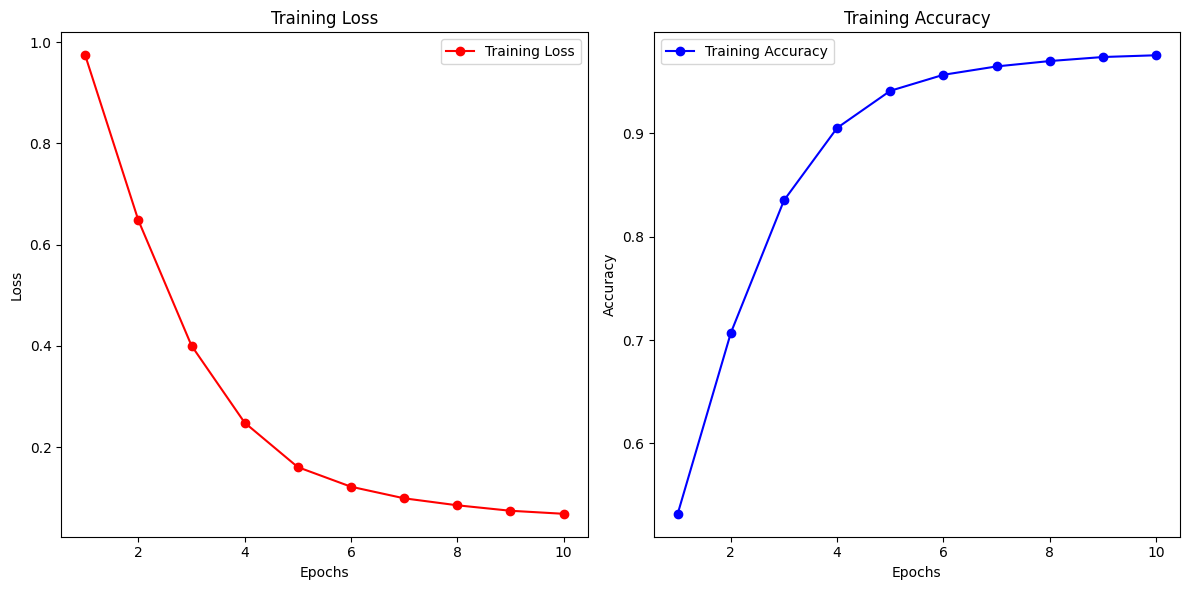

In [15]:
import matplotlib.pyplot as plt

# Sample data: Replace these with your actual arrays
epochs = list(range(1, 11))  # Assuming 20 epochs
training_loss = [0.9741, 0.6481, 0.4004, 0.2482, 0.1604, 0.1217, 0.0988, 0.0850, 0.0742, 0.0682]
training_accuracy = [0.5319, 0.7070, 0.8353, 0.9054, 0.9413, 0.9568, 0.9649, 0.9701, 0.9740, 0.9757]

# Plotting
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy', color='blue', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()